# <center>Image captioning model training experiment</center>
Same as main [training.ipynb](../training.ipynb) but with `d_model=128` and `num_heads=4`

In [1]:
import os
os.chdir('..')
# Project imports
from src.net.model import Model
from src.data_processing.dataset import FlickrDataset, Collate
from src.data_processing.vocabulary import Vocabulary
from src.utils.predictor import Predictor
from src.utils.history import History
os.chdir('extra_research')
# Third party imports
import pandas as pd
import torch
import lightning as L
from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import CSVLogger
from multiprocessing import cpu_count
torch.set_float32_matmul_precision('high')

# Project constants
NUM_WORKERS = cpu_count()
MAX_EPOCHS = 19
BATCH_SIZE = 32
IMGS_PATH = '/mnt/s/CV/flickr30k/flickr30k_images'
CAPTIONS_PATH = '/mnt/s/CV/flickr30k/results.csv'
# Model hyperparametres
D_MODEL = 128
NUM_HEADS = 4
LR_START = 5e-5
GAMMA = 0.95

## Initialize vocabulary, datasets and dataloaders

In [2]:
df = pd.read_csv(CAPTIONS_PATH, sep='|')
vocab = Vocabulary(df[' comment'])

dataset_train = FlickrDataset(IMGS_PATH, df, vocab, 'train')
dataset_valid = FlickrDataset(IMGS_PATH, df, vocab, 'valid')
dataset_test = FlickrDataset(IMGS_PATH, df, vocab, 'test')

collate = Collate(pad_idx=vocab.word2idx['<PAD>'])
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate, num_workers=NUM_WORKERS)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate, num_workers=NUM_WORKERS)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate, num_workers=NUM_WORKERS)

print(f'Vocabulary size: {len(vocab)}')
print(f'Train size: {len(dataset_train)}')
print(f'Val/test size: {len(dataset_valid)}/{len(dataset_test)}')

Vocabulary size: 7736
Train size: 143023
Val/test size: 7946/7946


## Configure model and callbacks

In [3]:
# Model
config = dict(
    vocab=vocab,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    lr_start=LR_START,
    gamma=GAMMA
)
model = Model(**config).cuda()
# Callbacks and logger
logger = CSVLogger('./logs')
lr_monitor_callback = LearningRateMonitor(logging_interval='step')
checkpoint_callback = ModelCheckpoint(
    dirpath='./weights',
    filename='checkpoint_extra',
    save_weights_only=True,
    mode='min',
    monitor='val_CE'
)
# early_stop_callback = EarlyStopping(
#     monitor='val_CE',
#     min_delta=0.05,
#     patience=5,
#     mode='min'
# )

## Training

In [4]:
trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    enable_checkpointing=True,
    callbacks=[
        checkpoint_callback,
        lr_monitor_callback,
        # early_stop_callback
    ], 
    logger=logger, 
    log_every_n_steps=len(dataloader_train) # Every epoch
)
trainer.fit(model=model, train_dataloaders=dataloader_train, val_dataloaders=dataloader_valid)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/screamer/anaconda3/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: UserWarning:

Checkpoint directory /home/deep_learning/Image captioning/extra_research/weights exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 58.4 M
1 | decoder | Decoder | 9.5 M 
------------------------------------
9.8 M     Trainable params
58.1 M    Non-trainable params
67.9 M    Total params
271.635   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=19` reached.


## Evaluation on test set

In [5]:
trainer.test(model, dataloaders=dataloader_test, ckpt_path='./weights/checkpoint_extra-v1.ckpt');

Restoring states from the checkpoint path at ./weights/checkpoint_extra-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./weights/checkpoint_extra-v1.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_CE          │    2.5969467163085938     │
└───────────────────────────┴───────────────────────────┘

## Load best checkpoint and draw history

In [6]:
model = model.__class__.load_from_checkpoint('./weights/checkpoint_extra-v1.ckpt', vocab=vocab)

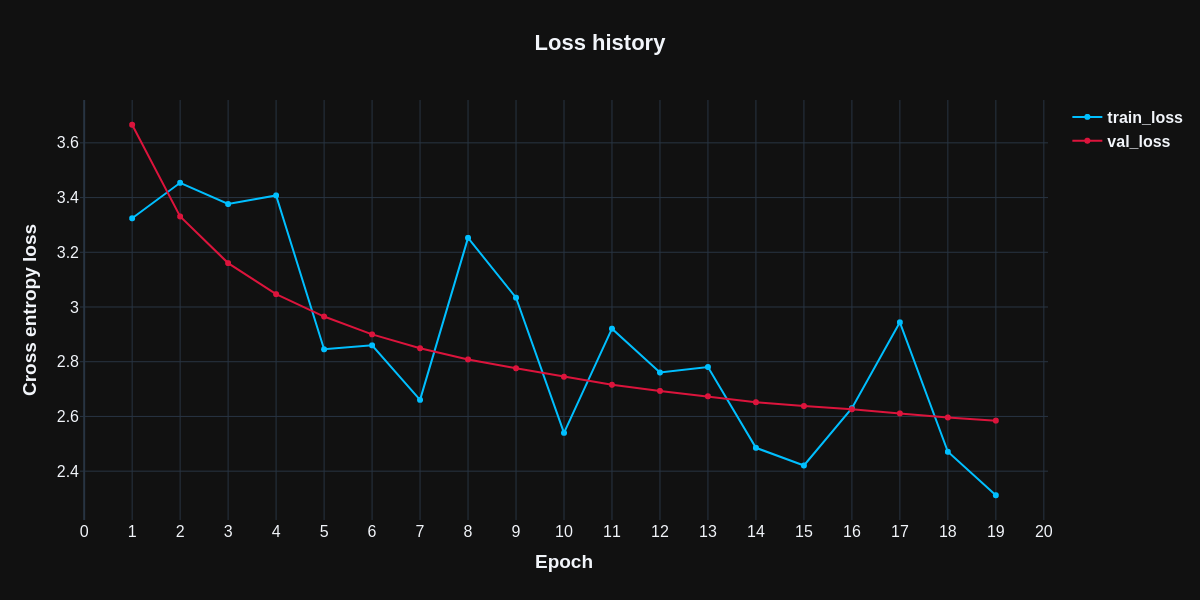

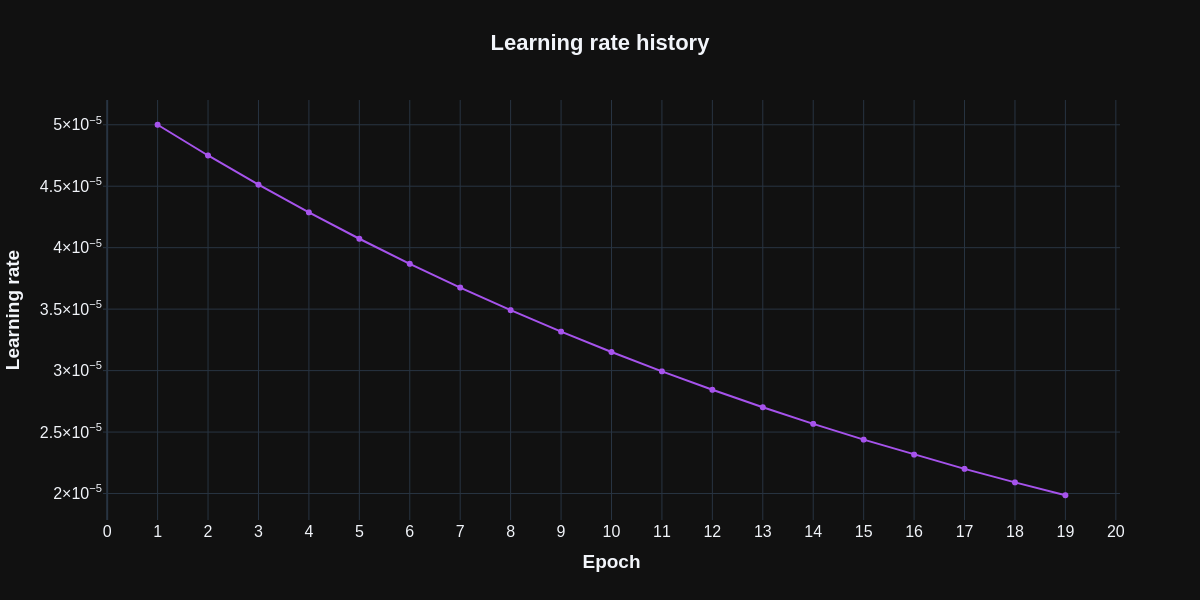

In [7]:
history_visualizer = History('./logs/lightning_logs/version_1/metrics.csv')
history_visualizer.draw_history()

## Visualize predictions from test set

two men are cooking in a kitchen .


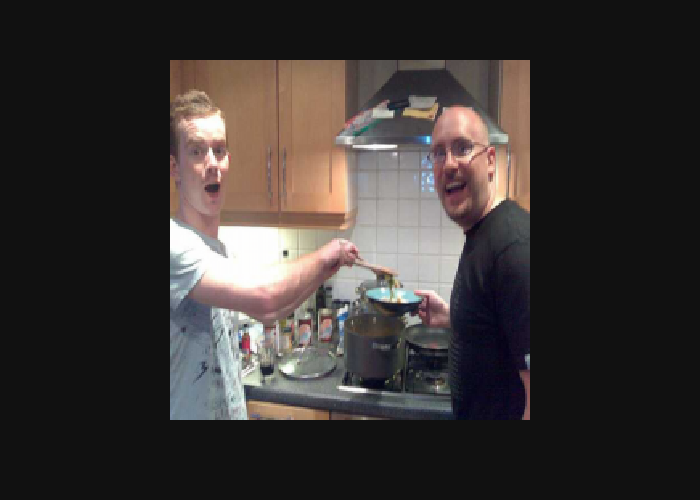

two men are sitting on a bench and one is playing a guitar .


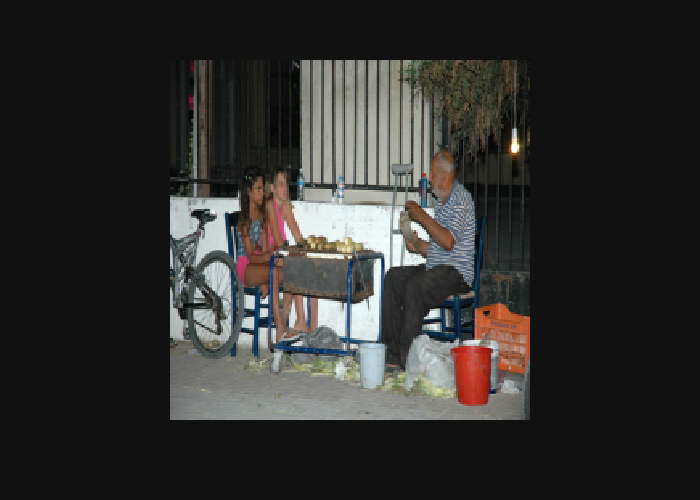

a woman is applying mascara on her cellphone .


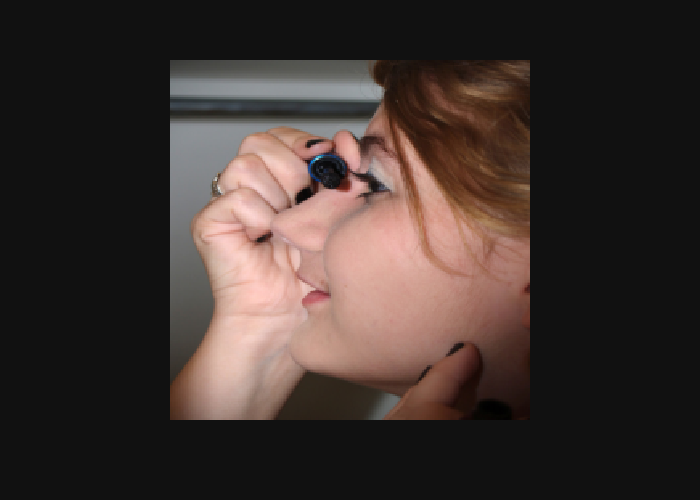

a man in a blue shirt is standing in a tractor with a black and white car .


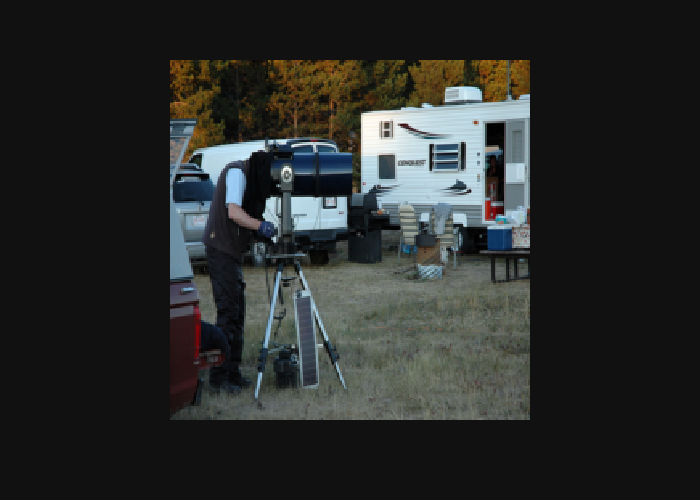

three people sitting on a rock .


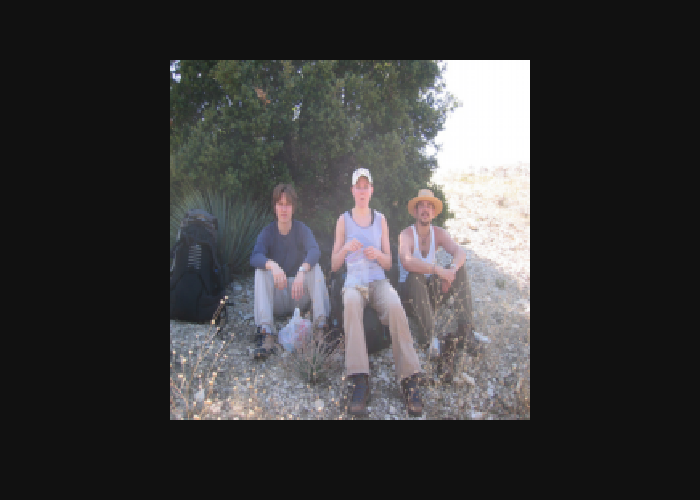

two women are practicing martial arts in a gym .


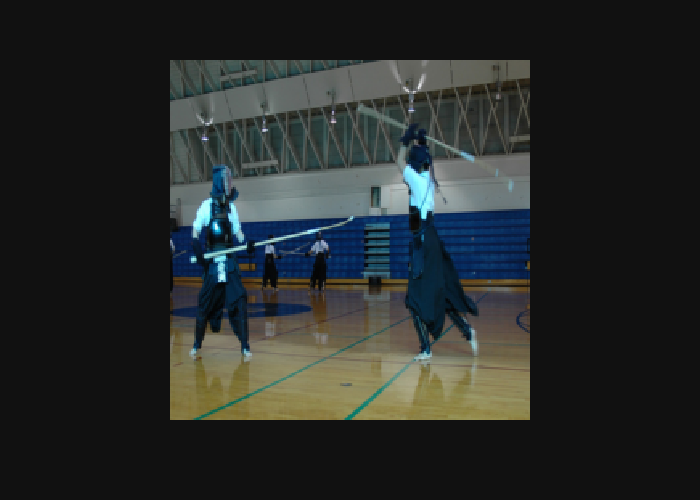

a little girl in a red shirt and blue shorts is playing with a soccer ball .


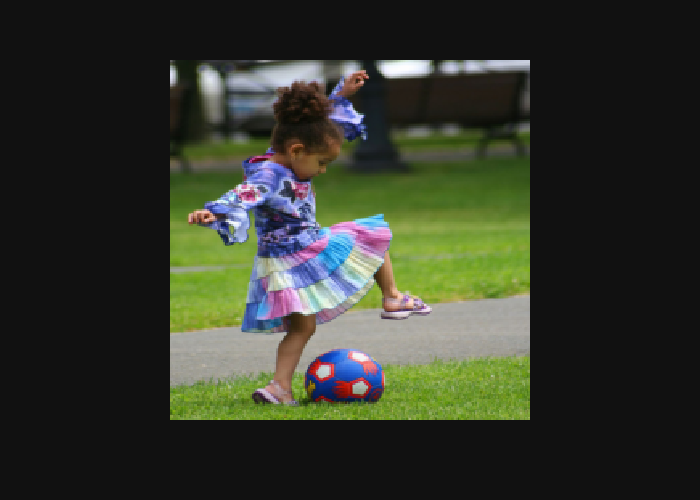

a man in a blue shirt is riding a boat on a boat .


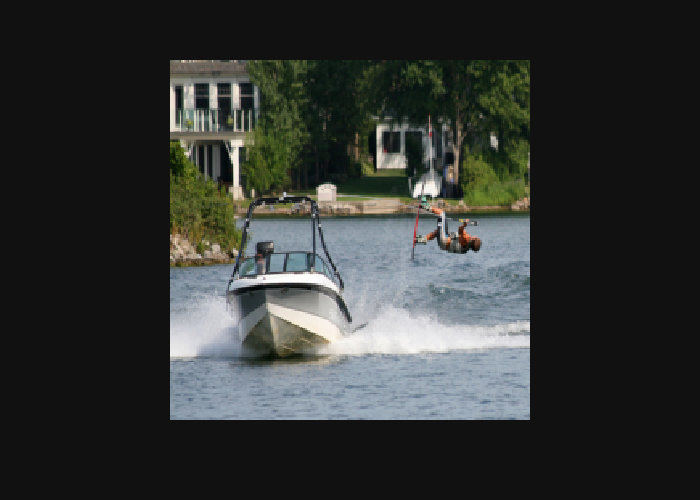

two children playing on the beach .


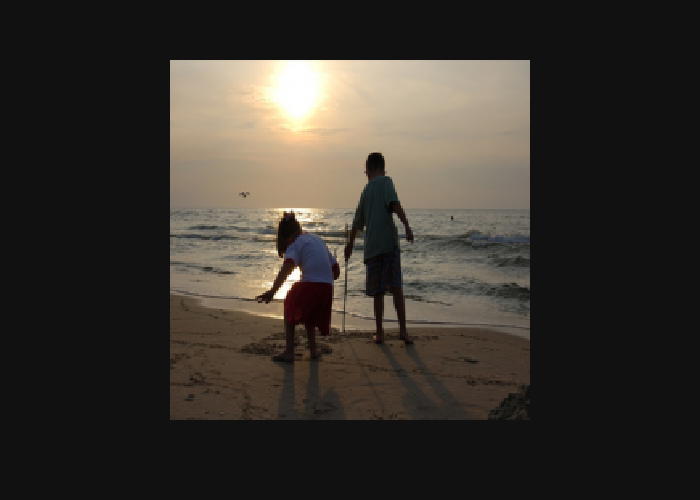

a woman in a black shirt is standing in front of a sign .


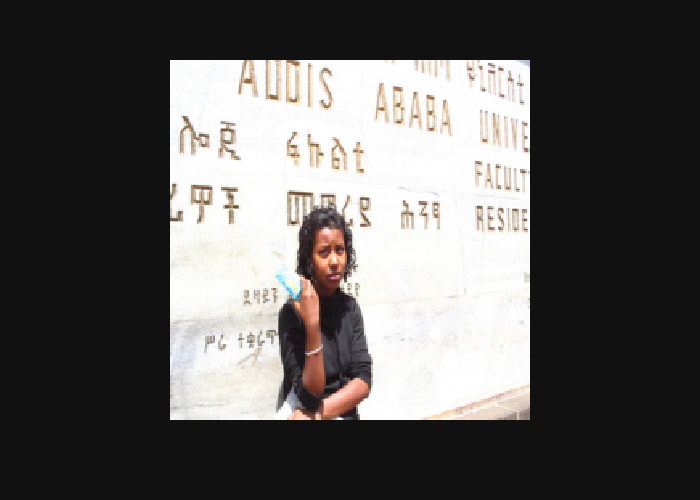

In [8]:
predictions_visuazlier = Predictor()
predictions_visuazlier.caption_dataloader(dataloader=dataloader_test, model=model, n_samples=10)